# Speeding up Python Code

This Notebook will look at techniques for speeding up Python code. Python is an interpreted language (in comparison to a compiled language like Java or any C language). This has many advantages to the programmer such as not having to declare the type of every variable or to send our code to a compiler before running. However, it has the disadvantage of meaning code is usually slower to run. While this won't matter much of the time, if we are performing data engineering on large datasets, and don't have access to something like PySpark on a cluster (previous tutorial), speed starts to matter. We'll begin by looking at vectorization.

## Vectorization
Because of the known problems of working with Python at scale, many packages (in this case _numpy)_ have implemented vectorised solutions for common mathematical problems. The basic idea is that the operation is performed on a whole vector of data rather than having to iterate through each item with a for loop. We can see this at work below: 

In [1]:
import numpy as np

# use a random seed to ensure results are always the same
np.random.seed(444)

# create a set of values that can be either False or True (randomly picked)
x = np.random.choice([False, True], size=100000)
x

array([ True, False,  True, ...,  True, False,  True])

 We will compare a hand-written for loop with a _numpy_ vectorised solution:

In [2]:
def count_transitions(x) -> int:
    count = 0
    for i, j in zip(x[:-1], x[1:]):
        if j and not i:
            count += 1
    return count

print(f"Our function: {count_transitions(x)}")

print(f"The numpy function: {np.count_nonzero(x[:-1] < x[1:])}")

Our function: 24984
The numpy function: 24984


We can see they produce the same result - but which is faster? We can use the appropraitely named _timeit_ function to find out:

In [3]:
from timeit import timeit

# import our function, x and the other packages
setup = 'from __main__ import count_transitions, x; import numpy as np; from timeit import timeit'

# run it 1000 times for better accuracy
num = 1000

# t1 is our function; t2 is the numpy version
t1 = timeit('count_transitions(x)', setup=setup, number=num)
t2 = timeit('np.count_nonzero(x[:-1] < x[1:])', setup=setup, number=num)

# print results
print(f"Our function time = {t1}")
print(f"The numpy function time = {t2}")

Our function time = 7.7662579
The numpy function time = 0.1318078000000007


_numpy_ has blown us out of the water via vectorization. Let's try another:

In [4]:
people = ['James', 'John', 'Mark', 'Jordan']

# native function
def namer(person):
    if person == 'John':
        print('Hello Boss')
    elif person == 'James':
        print('Have you done something different with your hair?')
    elif person == 'Jordan':
        print('Is it Jordon or Jordan?')
    else:
        print('I have nothing to say to you')

# call the native function
for person in people:
    namer(person)

print("\n")
    
# call the numpy equivalent
for person in people:
    print(np.where(person == 'John', 'Hello Boss', np.where(person == 'James', \
            'Have you done something different with your hair?', np.where(person == 'Jordan', \
            'Is it Jordon or Jordan?', 'I have nothing to say to you'))))

Have you done something different with your hair?
Hello Boss
I have nothing to say to you
Is it Jordon or Jordan?


Have you done something different with your hair?
Hello Boss
I have nothing to say to you
Is it Jordon or Jordan?


Again, the results are equivalent. But which is faster?

In [5]:
setup = 'from __main__ import namer, people; import numpy as np; from 	timeit import timeit'
num = 10

t1 = timeit('[namer(person) for person in people]', setup=setup, number=num)
t2 = timeit("[print(np.where(person == 'John', 'Hello Boss', np.where(person == 'James', 'Have you done something different with your hair?', np.where(person == 'Jordan', 'Is it Jordon or Jordan?', 'I have nothing to say to you')))) for person in people]", setup=setup, number=num)

print("\n")
print(f"Our function time = {t1}")
print(f"The numpy function time = {t2}")

Have you done something different with your hair?
Hello Boss
I have nothing to say to you
Is it Jordon or Jordan?
Have you done something different with your hair?
Hello Boss
I have nothing to say to you
Is it Jordon or Jordan?
Have you done something different with your hair?
Hello Boss
I have nothing to say to you
Is it Jordon or Jordan?
Have you done something different with your hair?
Hello Boss
I have nothing to say to you
Is it Jordon or Jordan?
Have you done something different with your hair?
Hello Boss
I have nothing to say to you
Is it Jordon or Jordan?
Have you done something different with your hair?
Hello Boss
I have nothing to say to you
Is it Jordon or Jordan?
Have you done something different with your hair?
Hello Boss
I have nothing to say to you
Is it Jordon or Jordan?
Have you done something different with your hair?
Hello Boss
I have nothing to say to you
Is it Jordon or Jordan?
Have you done something different with your hair?
Hello Boss
I have nothing to say to yo

No real difference. Why is that? Our _numpy_ function in this case is not numerical its text values. There is no way to vectorise this problem we just have to do a slow loop.

## Cython
Cython creates code that can be written (mostly) in Python but is then compiled to C. In other words, we can get those benefits of working in a compiled language but using a Python base. Unfortunately this does mean we have to save/compile everything so its not great for working in Notebooks. If you want to learn more have a look at the following [tutorial](https://cython.readthedocs.io/en/latest/src/tutorial/cython_tutorial.html).

## Numba / Just-in-Time Compilation
An alternative to Cython is Numba - a package made by the same people as _pandas_. The basic idea is that it takes a part of your code (a function) and compiles it to machine code for faster run times. Here is an example from our earlier code:

In [6]:
from numba import jit

# the @jit decorator tells Python to compile this function
@jit
def numba_counter(x):
    count = 0
    for i, j in zip(x[:-1], x[1:]):
        if j and not i:
            count += 1
    return count

np.random.seed(444)
x = np.random.choice([False, True], size=1000000)

We'll again compare it to our earlier function:

In [7]:
setup = 'from __main__ import count_transitions, numba_counter, x; import numpy as np; from timeit import timeit; from numba import jit'
num = 1000

t1 = timeit('count_transitions(x)', setup=setup, number=num)
t2 = timeit('numba_counter(x)', setup=setup, number=num)

print(f"Our function time = {t1}")
print(f"The jit compiled function time = {t2}")

Our function time = 76.5379552
The jit compiled function time = 1.1787334999999928


As we can see a considerable speed up again and a comparable time to the native _numpy_ vectorised solution.

A useful cheatsheet for finding speed-ups is below:
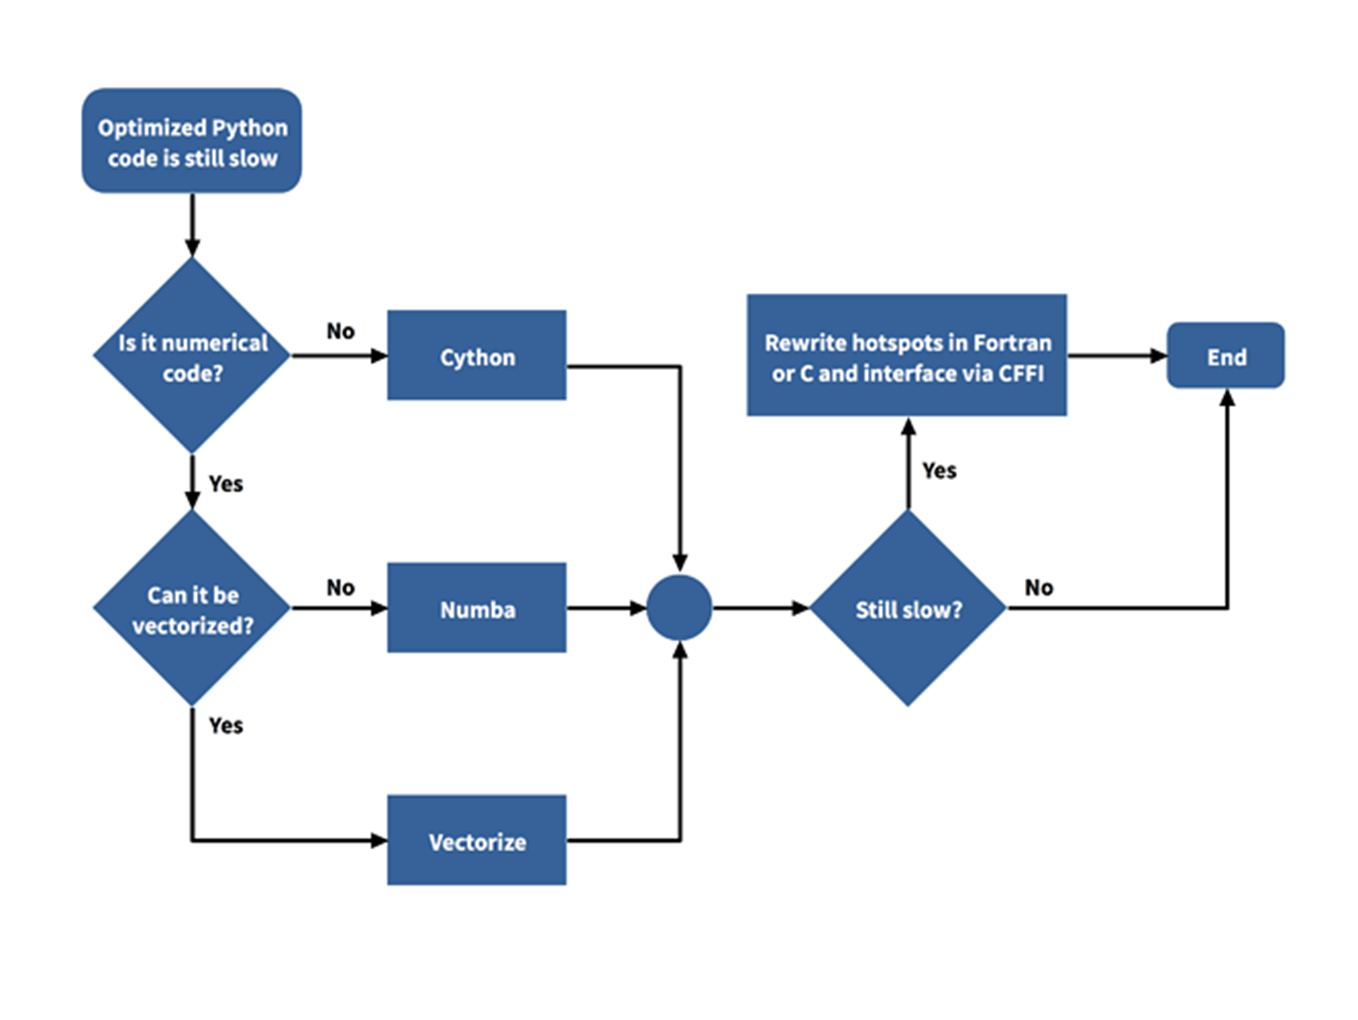